In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pathlib
import pickle
ks = tf.keras
SEED = 42

In [2]:
with open('sentences_de.pkl', 'rb') as f:
    sentences_de = pickle.load(f)
with open('sentences_en.pkl', 'rb') as f:
    sentences_en = pickle.load(f)

In [3]:
vocab_size = 5000
max_length = 120
text_vec_layer_en = ks.layers.TextVectorization(vocab_size, standardize='lower_and_strip_punctuation',
    split='whitespace')
text_vec_layer_de = ks.layers.TextVectorization(vocab_size, standardize='lower_and_strip_punctuation',
    split='whitespace')
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_de.adapt([f'<SOS> {s} <EOS>' for s in sentences_de])

In [4]:
# training data:
X_train = tf.constant(sentences_en[:200000])
X_valid = tf.constant(sentences_en[200000:])
X_train_dec = tf.constant([f'<SOS> {s}' for s in sentences_de[:200000]])
X_valid_dec = tf.constant([f'<SOS> {s}' for s in sentences_de[200000:]])
Y_train = text_vec_layer_de([f'{s} <EOS>' for s in sentences_de[:200000]])
Y_valid = text_vec_layer_de([f'{s} <EOS>' for s in sentences_de[200000:]])

In [15]:
X_train_dec[:32]

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'<SOS> Geh.', b'<SOS> Hallo!', b'<SOS> Gr\xc3\xbc\xc3\x9f Gott!',
       b'<SOS> Lauf!', b'<SOS> Lauf!', b'<SOS> Potzdonner!',
       b'<SOS> Donnerwetter!', b'<SOS> Kopf runter!', b'<SOS> Feuer!',
       b'<SOS> Hilfe!', b'<SOS> Zu H\xc3\xbclf!', b'<SOS> Bleib!',
       b'<SOS> Stopp!', b'<SOS> Anhalten!', b'<SOS> Warte!',
       b'<SOS> Warte.', b'<SOS> Fang an.', b'<SOS> Mache es!',
       b'<SOS> Tue es.', b'<SOS> Mach weiter.', b'<SOS> Hallo!',
       b'<SOS> Sers!', b'<SOS> Beeil dich!', b'<SOS> Schnell!',
       b'<SOS> Ich versteckte mich.', b'<SOS> Ich habe mich versteckt.',
       b'<SOS> Ich rannte.', b'<SOS> Ich verstehe.', b'<SOS> Aha.',
       b'<SOS> Ich versuche es.', b'<SOS> Ich probiere es.',
       b'<SOS> Ich hab gewonnen!'], dtype=object)>

In [105]:
# next thing to do: don't use any numpy. Only use tf methods

def my_categorical_loss(y_true, y_pred):
  '''
  have to eliminate padding in each sample of the batch y_pred and the batch y_true
  '''
  batch_size = y_true.shape[0]
  losses = np.ones(shape=batch_size)*1000
  for i in range(batch_size):
    y_true_sample = y_true[i] # sparse. 0 means padding. 
    y_pred_sample = y_pred[i]
    y_true_sample = np.array(y_true_sample)
    y_pred_sample = np.array(y_pred_sample)
    len_no_padding = np.sum(y_true_sample != 0)
    assert len_no_padding > 0

    ce = 0 # cross entropy
    for k in range(len_no_padding):
      pred_probs = y_pred_sample[k] # probability distribution for the k^th word
      true_word_ind = y_true_sample[k]
      ce -= np.log(pred_probs[true_word_ind]) # PROBLEM: THIS LOSS MIGHT FAVOR SHORT SEQUENCES BECAUSE YOU ARE JUST SUMMING THE LOSS OF EACH
      # WORD TOGETHER

    losses[i] = ce
  
  return tf.constant(losses, dtype='float32')

In [106]:
# Model:

encoder_inputs = ks.layers.Input(shape=[], dtype=tf.string, name='encoder_inputs')
encoder_input_ids = text_vec_layer_en(encoder_inputs)

'''
Next, reverses each sentence.
    for example,
    inputs: 
      [[  6, 154,   4,   0],
       [  6,  74,  79,   4],
       [  1,   0,   0,   0]]
      is a batch (tf tensor) containing three sentences
    return
      [[  0, 4, 154, 6],
       [  4, 79, 74, 6],
       [  0,  0,  0, 1]]
'''
reverse_layer = ks.layers.Lambda(lambda a: tf.reverse(a, axis=[-1])) 
encoder_input_ids = reverse_layer(encoder_input_ids)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True, name='en_emb')
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)

encoder = ks.layers.LSTM(512, return_state=True, name='en_lstm')
encoder_output, *encoder_state = encoder(encoder_embeddings)

##########################

decoder_inputs = ks.layers.Input(shape=[], dtype=tf.string, name='decoder_inputs')
decoder_input_ids = text_vec_layer_de(decoder_inputs)

decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True, name='de_emb')
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

decoder = ks.layers.LSTM(512, return_sequences=True, name='de_lstm')
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

output_layer = ks.layers.Dense(vocab_size, activation='softmax', name='out')
Y_prob = output_layer(decoder_outputs)

##############################

mod = ks.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_prob])
mod.compile(optimizer='nadam',
                 loss=my_categorical_loss,
                 metrics=['accuracy'])

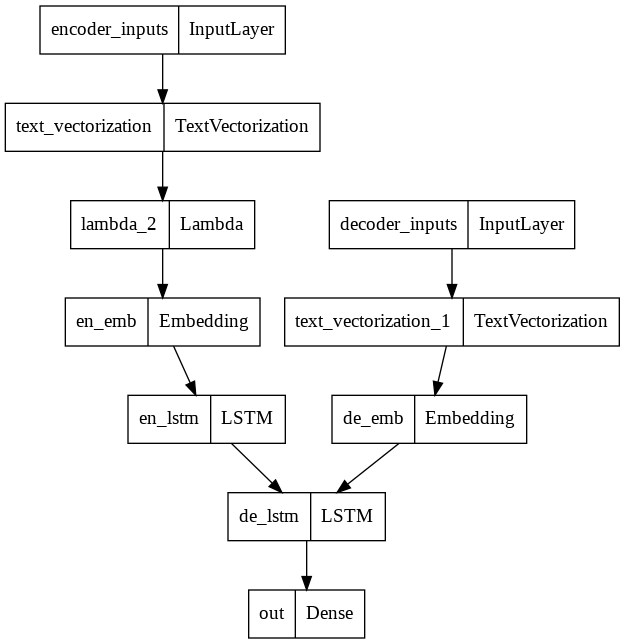

In [107]:
ks.utils.plot_model(mod)

In [55]:
y = mod.predict((X_train[10000:10032], X_train_dec[10000:10032]))
print(y.shape)
print(y[0]) # first sample in batch

1/1 [==============================] - 0s 21ms/step
(32, 8, 5000)
[[0.00019988 0.00019952 0.00020001 ... 0.00019998 0.00019975 0.00020016]
 [0.00019952 0.00020006 0.00019999 ... 0.00020006 0.00019966 0.00019975]
 [0.00019944 0.00020033 0.00019992 ... 0.00020018 0.00019966 0.00019973]
 ...
 [0.00019945 0.00020022 0.0002001  ... 0.0002003  0.00019982 0.00020016]
 [0.0002     0.0002     0.0002     ... 0.0002     0.0002     0.0002    ]
 [0.0002     0.0002     0.0002     ... 0.0002     0.0002     0.0002    ]]


In [44]:
y_true = Y_train[10000:10032]
samp = y_true[0] # first sample in batch
print(samp != 0)
np.sum((samp != 0).numpy())

tf.Tensor(
[ True  True  True  True  True  True False False False False False False
 False False False False False False False False], shape=(20,), dtype=bool)


6

In [45]:
print(samp)

tf.Tensor(
[  8  16  22 495 130   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)


In [49]:
ind = 100000
print(X_train_dec[ind])
print(Y_train[ind])

tf.Tensor(b'<SOS> Sie wissen nicht alles.', shape=(), dtype=string)
tf.Tensor(
[ 10 145   6 115   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)


In [53]:
text_vec_layer_de.get_vocabulary()[:10] # index 3 corresponds to 'sos'

['', '[UNK]', 'sos', 'eos', 'ich', 'tom', 'nicht', 'ist', 'das', 'du']

In [103]:
# example
y_pred = mod.predict((X_train[10000:10032], X_train_dec[10000:10032]))
y_true = Y_train[10000:10032]
my_categorical_loss(y_true, y_pred)

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([51.099957, 68.13993 , 51.105804, 51.099243, 34.066654, 34.07039 ,
       34.065918, 25.552368, 34.06981 , 42.58799 , 51.10169 , 51.101364,
       51.10432 , 51.10337 , 34.073658, 25.552242, 34.066547, 34.065205,
       42.587822, 25.547106, 51.103764, 42.585014, 42.588146, 34.065094,
       34.06649 , 34.077377, 34.065178, 34.067966, 42.58597 , 42.583435,
       51.100025, 25.55503 ], dtype=float32)>

In [108]:
from google.colab import drive
drive.mount('/content/gdrive')

CHECKPOINT_PATH = '/content/gdrive/My Drive/Colab/checkpoints/translation0102.ckpt' # for ModelCheckpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH, 
    verbose=1,
    save_freq = 'epoch')

mod.fit((X_train, X_train_dec), Y_train, epochs=10, validation_data=((X_valid, X_valid_dec), Y_valid), callbacks=[cp_callback])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch 1/10


NotImplementedError: ignored

------------------------------------------------------------

In [28]:
a = [[  6, 154,   4,   0],
       [  6,  74,  79,   4],
       [  1,   0,   0,   0]]
a = tf.constant(a)
tf.reverse(a, axis=[-1])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[  0,   4, 154,   6],
       [  4,  79,  74,   6],
       [  0,   0,   0,   1]], dtype=int32)>